In [1]:
%run reward.ipynb

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [2]:
%run dataReadIn.ipynb

[['1. d4 e6 2. Nf3 d6 3. e4 h6 4. Bd3 a6 5. O-O b6 6. h3 Bb7 7. c3 Nd7 8. Bf4 Ne7 9. Nbd2 Ng6 10. Bh2 e5 11. Rfe1 Be7 12. Qb3 Bf6 13. d5 Be7 14. c4 Ngf8 15. Qd1 g5 16. Kh1 Ng6 17. Ng1 Nf4 18. Bxf4 gxf4 19. Ndf3 Rhg8 20. Ne2 Nc5 21. Bc2 Bf8 22. Reg1 Bc8 23. h4 Qd7 24. b4 Nb7 25. c5 bxc5 26. Ba4 cxb4 27. Bxd7+ Bxd7 28. Rac1 Nc5 29. Qd2 a5 30. Qc2 Ba4 31. Qc4 Rab8 32. Nd2 Bb5 33. Qxb5+ Rxb5 34. f3 Kd7 35. Nb3 Nd3 36. Rc6 Nf2+ 37. Kh2 Nd3 38. Ra6 Nc5 39. Rxa5 Rxa5 40. Nxa5 Be7 41. Kh3 Ra8 42. Nc6 Rxa2 43. Nc1 Ra4 44. g4 b3 45. Rg2 Ra1 46. Nxb3 Nxb3 47. g5 h5 48. g6 Rh1+ 49. Rh2 Rxh2+ 50. Kxh2 fxg6 51. Kh3 Nd2 52. Kg2 Bxh4 53. Nb8+ Kc8 54. Nc6 Bf6 55. Na7+ Kd7 56. Nc6 h4 57. Nb8+ Kc8 58. Nc6 g5 59. Na7+ Kd7 60. Nc6 h3+ 61. Kh2 Nxf3+ 62. Kxh3 Nd2 63. Nb8+ Kc8 64. Nc6 Nxe4 65. Kg4 Nc3 66. Nb4 Kd7 67. Kf3 e4+ 68. Kf2 g4 69. Kf1 g3 70. Kg2 Be5 71. Nc6 Nxd5 72. Nxe5+ dxe5 73. Kf1 Ke6 74. Ke2 Ne3 75. Ke1 Kf5 76. Ke2 Kg4 77. Ke1 Kf3 78. Kd2 g2 79. Kc3 g1=Q 0-1'], ['1. d4 d5 2. Nc3 e6 3. f3 Nf6 4. 

In [3]:
board = chess.Board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [7]:
def total_squares(board):
    pieces = ["Q", "R", "B", "N"]
    
    white = sum([squarecontrol(piece, board) for piece in pieces])
    try:
        move = board.pop()
        black = sum([squarecontrol(piece, board) for piece in pieces])
        board.push_san(board.san(move))
    except:
        black = white
    return white - black

def material_diff(board):
    white, black = material(board)
    return white - black

def twobishops_diff(board):
    white, black = twobishops(board)
    return white - black

def bias(board):
    return 1

In [5]:
def eval_f(functions, weights, board):
    return sum([f(board) * w for f, w in zip(functions, weights)])

def eval_last_r(move):
    if move[0] == "1":
        return 1
    if move[0] == "0":
        return -1
    return 0

In [6]:
def train(game, functions, weights, alpha, gamma):
    board = chess.Board()
    for i, move in enumerate(game):
        if game[-1] == move:
            current_v = eval_f(functions, weights, board)
            r = eval_last_r(move)
            next_v = r
            diff = r + gamma * next_v - current_v
            weights = [w + alpha * diff * f(board) for f, w in zip(functions, weights)]
        
        else:
            if move[:4] == "[%eva":
                # hijack eval :)
                r = int(game[move + 1][:-1])
                current_v = eval_f(functions, weights, board)
                next_v = eval_f(functions, weights, board)
                diff = r + gamma * next_v - current_v
                weights = [w + alpha * diff * f(board) for f, w in zip(functions, weights)]
            
            if move != '{' and move != '}':
                try:
                    # Move white
                    if i % 2 == 0:
                        current_v = eval_f(functions, weights, board)
                        board.push_san(move)
                        r = 0
                        next_v = eval_f(functions, weights, board)

                        diff = r + gamma * next_v - current_v
                        weights = [w + alpha * diff * f(board) for f, w in zip(functions, weights)]
                    else:
                        board.push_san(move)
                except:
                    print("Unable to process move: ", move)
                    return weights
        weights = [0 if sum(weights) == 0 else w / sum(weights) for w in weights]
    return weights

In [28]:
# Gets the greedy best move 
def get_best_move(board, functions, weights, color_factor, depth):
    if depth <= 0:
        vals = []
        for move in board.generate_legal_moves():
            board.push_san(board.san(move))
            vals += [color_factor * eval_f(functions, weights, board)]
            board.pop()
        moves = [board.san(move) for move in board.generate_legal_moves()]
        move = moves[vals.index(max(vals))]
        return move, max(vals)
    
    else:
        vals = []
        moves = []
        for move in board.generate_legal_moves():
            board.push_san(board.san(move))
            best_move, val = get_best_move(board, functions, weights, 
                                      -1 * color_factor, depth - 1)
            board.pop()
            vals += [vals]
            moves += [board.san(move)]
        move = moves[vals.index(max(vals))]
        return move, max(vals)

def play_best_move(board, functions, weights):
    move, val = get_best_move(board, functions, weights, 1, 2)
    board.push_san(move)

In [19]:
# Training!
functions = [bias, kingsafety, total_squares, material_diff, twobishops_diff]
weights = [0] * len(functions)

for game in gamesData[:50]:
    moves = gameMoves(game)
    weights = train(moves, functions, weights, 0.05, 0.1)

print(weights)

Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
[-0.043977344868032515, 0.0026386899375218896, 0.9493513111565353, 0.09194810070721157, 3.9243066763618624e-05]


In [38]:
# More training!
for game in gamesData[:1000]:
    moves = gameMoves(game)
    weights = train(moves, functions, weights, 0.05, 0.1)

Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable to process move:  [%eval
Unable t

In [ ]:
weights = [0.2144193889366526, 1.1077753101097993, -0.26826920715475205, -0.05392549189169986]

In [29]:
board = chess.Board()
play_best_move(board, functions, weights)

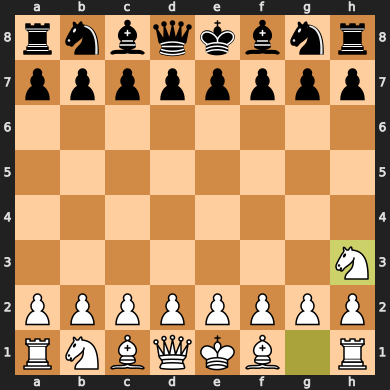

In [30]:
board

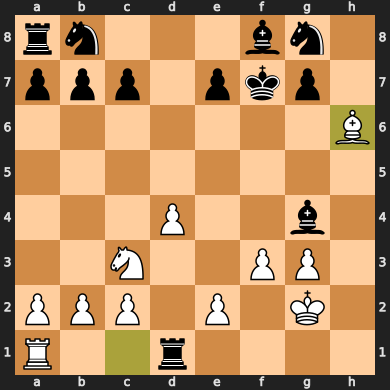

In [51]:
board.push_san("c8g4")
play_best_move(board, functions, weights)
board

In [52]:
print(weights)

[0.2144193889366526, 1.1077753101097993, -0.26826920715475205, -0.05392549189169986]
